In [1]:
import sys
from ruamel.yaml import YAML as ym
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
#import pandas as pd

sys.path.append("../../preprocessing")
from generate_chirp import generate_chirp

sys.path.append("../")
import processing as pr

In [2]:
def plot_chirp(chirp, ts, fs):
    fig, axs = plt.subplots(2,1)
    axs[0].plot(ts*1e6, np.real(chirp), label='I')
    axs[0].plot(ts*1e6, np.imag(chirp), label='Q')
    axs[0].set_xlabel('Time [us]')
    axs[0].set_ylabel('Samples')
    axs[0].set_title('Chirp -- Time Domain')
    axs[0].legend()

    freqs = np.fft.fftshift(np.fft.fftfreq(chirp.size, d=1/fs))
    chirp_fft = np.fft.fftshift(20*np.log10(np.abs(np.fft.fft(chirp))))
    axs[1].plot(freqs/1e6, chirp_fft)
    axs[1].set_xlabel('Frequency [MHz]')
    axs[1].set_ylabel('Power [dB]')
    axs[1].set_title('Chirp -- Frequency Domain')
    axs[1].grid()
    fig.tight_layout()

In [3]:
def plot_spectrum(data, fs):
    fig, axs = plt.subplots(2,1)
    freqs = np.fft.fftshift(np.fft.fftfreq(data.shape[0], d=1/fs))
    axs[0].plot(freqs/1e6, np.fft.fftshift(10*np.log10(np.abs(data))))
    axs[0].set_xlabel('Frequency [MHz]')
    axs[0].set_ylabel('Magnitude (Amplitude) [dB]')
    axs[0].set_title('Spectrum -- Magnitude')
    axs[0].legend()

    axs[1].plot(freqs/1e6, np.fft.fftshift(np.angle(data)))
    axs[1].set_xlabel('Frequency [MHz]')
    axs[1].set_ylabel('Phase [rad]')
    axs[1].set_title('Spectrum -- Phase')
    axs[1].grid()
    fig.tight_layout()

### Generate synthetic radargram (chirp and reflections) for initial testing

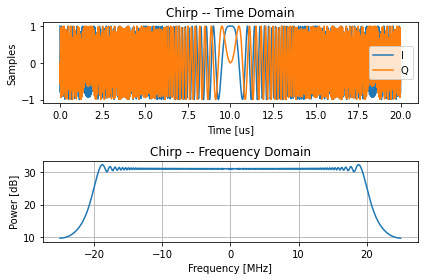

In [4]:
# generate synthetic radargram (chirp and reflections) for initial testing
synthetic_yaml_file = "../../config/synthetic_config.yaml"
yaml = ym()
with open(synthetic_yaml_file) as stream:
    synthetic_config = yaml.load(stream)
    fs = synthetic_config["PLOT"]["sample_rate"]    # Hertz
    num_rx_samples = int(synthetic_config['CHIRP']['rx_duration'] * synthetic_config['GENERATE']['sample_rate'])

ts, chirp = generate_chirp(synthetic_config)

plot_chirp(chirp, ts, fs)

1500


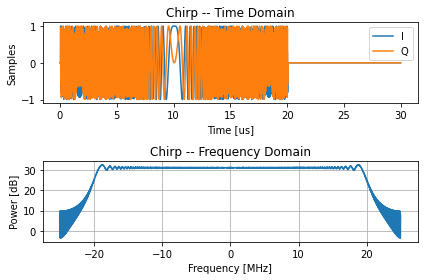

In [5]:
# delay chirp by 3 samples to represent surface reflection
surface_delay = 3 # samples

print(num_rx_samples)

chirp_surface_reflection = np.zeros(num_rx_samples, dtype=np.complex64) 
ts_rx = np.arange(0, num_rx_samples/fs, 1/fs)

chirp_surface_reflection[surface_delay:surface_delay+chirp.size] = chirp

plot_chirp(chirp_surface_reflection, ts_rx, fs)

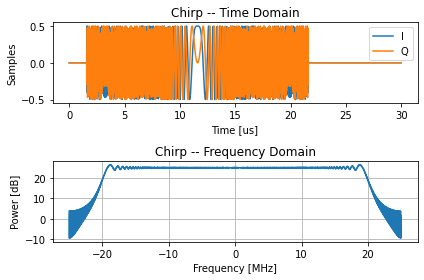

In [6]:
# delay chirp by 80 samples to represent bed reflection
bed_delay = 80 # samples

chirp_bed_reflection = np.zeros(num_rx_samples, dtype=np.complex64) 

chirp_bed_reflection[bed_delay:bed_delay+chirp.size] = 0.5 * chirp

plot_chirp(chirp_bed_reflection, ts_rx, fs)

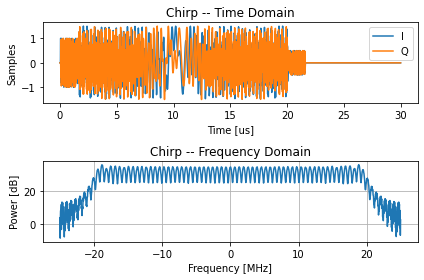

In [7]:
# add surface and bed reflections
chirp_rx = chirp_surface_reflection + chirp_bed_reflection
plot_chirp(chirp_rx, ts_rx, fs)

In [8]:
# make into sequence of received pulses
num_pulses = 1000
data_rx = np.repeat(chirp_rx, num_pulses)

# add noise
noise_mean = 0
noise_std = 0.3
#noise_rx = np.random.normal(noise_mean, noise_std, data_rx.shape) + 1j * np.random.normal(noise_mean, noise_std, data_rx.shape)
noise_rx = np.zeros_like(data_rx) # don't add noise

data_rx += noise_rx

### Load sample loopback data from Anna & Thomas for testing

### Load sample real data from Anna & Thomas for testing

### Do coherent summation and generate reference chirp

In [9]:
# do coherent summation if desired
num_coherent_sums = 1

data_rx_stacked = np.reshape(data_rx, (num_rx_samples, num_coherent_sums, -1))
data_rx_stacked = np.sum(data_rx_stacked, axis=1) / num_coherent_sums
print(data_rx_stacked.shape)

# assign reference chirp
ref_chirp = chirp

(1500, 1000)


### Do processing via the fft method

(1500, 1000)


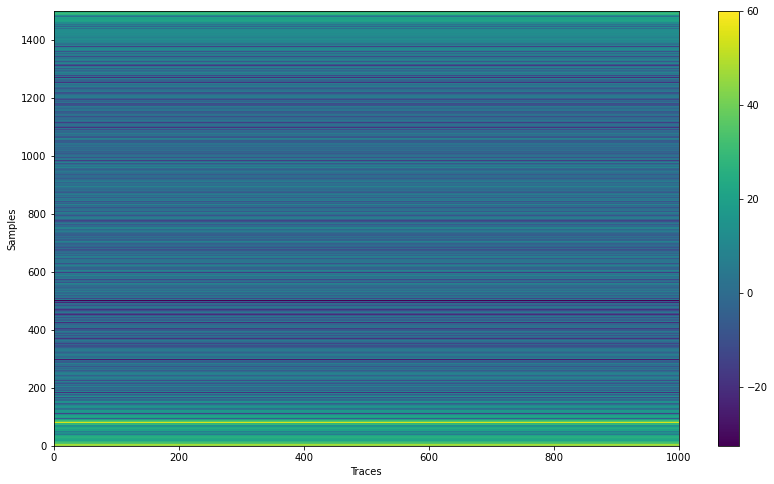

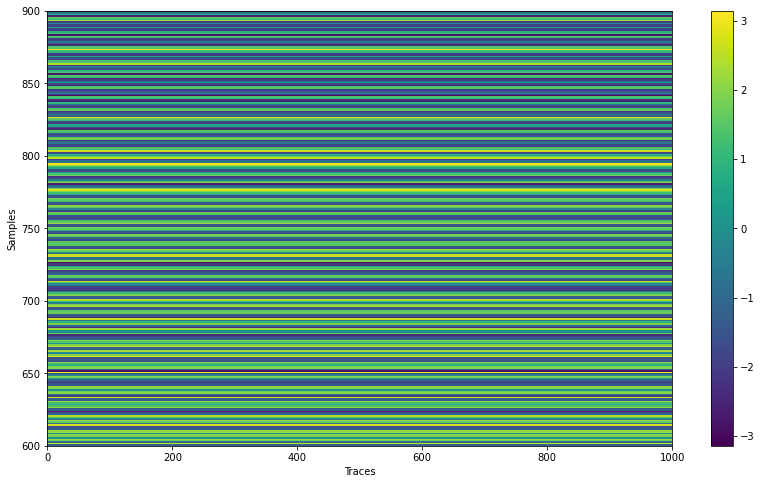

In [11]:
# do pulse compression using fft method -- no extra zero padding
nfft = num_rx_samples # number of samples in fft

data_tx_fft = np.fft.fft(ref_chirp, nfft) 
data_tx_fft = np.tile(data_tx_fft, (data_rx_stacked.shape[1], 1)).transpose()
print(data_tx_fft.shape)

data_rx_fft = np.fft.fft(data_rx_stacked, n=nfft, axis=0)

pc_fft = data_rx_fft * np.conjugate(data_tx_fft)
pc_nrxsamps = np.fft.ifft(pc_fft, axis=0)
#pc = np.fft.ifftshift(pc_nrxsamps)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_nrxsamps))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)

# fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
# im = ax.pcolormesh(20*np.log10(np.abs((pc))))
# ax.set_xlabel('Traces')
# ax.set_ylabel('Samples')
# ax.set_ylim((600, 900))
# fig.colorbar(im, ax=ax)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(np.angle((pc_nrxsamps)))
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
ax.set_ylim((600, 900))
fig.colorbar(im, ax=ax)

In [ ]:
# extract phase of the pulse compressed peak
# surface_idx_min, surface_idx_max = 750, 756
# bed_idx_min, bed_idx_max = 827, 833
surface_idx = 753
bed_idx = 830

print(pc.shape)
surface_phase = np.angle(pc[surface_idx,:])
bed_phase = np.angle(pc[bed_idx,:])

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(surface_phase, label='Surface')
ax.plot(bed_phase, label='Bed')
ax.set_xlabel('Traces')
ax.set_ylabel('Phase (rad)')
ax.legend()



In [ ]:
# estimate SNR
def estimate_snr(data, sig_idx, noise_idx_start):
    tol = 5
    sig_pwr = np.zeros(data.shape[1])
    for tr in np.arange(0, data.shape[1]):
        idx_min = int(np.maximum(0, sig_idx-tol))
        idx_max = int(np.minimum(data.shape[0], sig_idx+tol+1))
        sig = np.amax(data[idx_min:idx_max, tr])
        sig_pwr[tr] = np.abs(sig)**2

    noise = data[noise_idx_start:,:]
    noise_pwr = np.abs(noise)**2
    noise_pwr_rms = np.std(noise_pwr, axis=0)
    
    snr = sig_pwr / noise_pwr_rms
    
    return sig_pwr, noise_pwr_rms, snr

In [ ]:
surface_pwr, noise_pwr_rms, surface_snr = estimate_snr(pc, 753, 1000)
bed_pwr, _, bed_snr = estimate_snr(pc, 830, 1000)

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(10*np.log10(surface_snr), label='Surface')
ax.plot(10*np.log10(bed_snr), label='Bed')
ax.set_xlabel('Trace')
ax.set_ylabel('SNR (dB)')
ax.legend()

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(10*np.log10(surface_pwr), label='Surface')
ax.plot(10*np.log10(bed_pwr), label='Bed')
ax.plot(10*np.log10(noise_pwr_rms), label='Noise RMS')
ax.set_xlabel('Trace')
ax.set_ylabel('Signal Power (dB)')
ax.legend()

(2048, 1000)


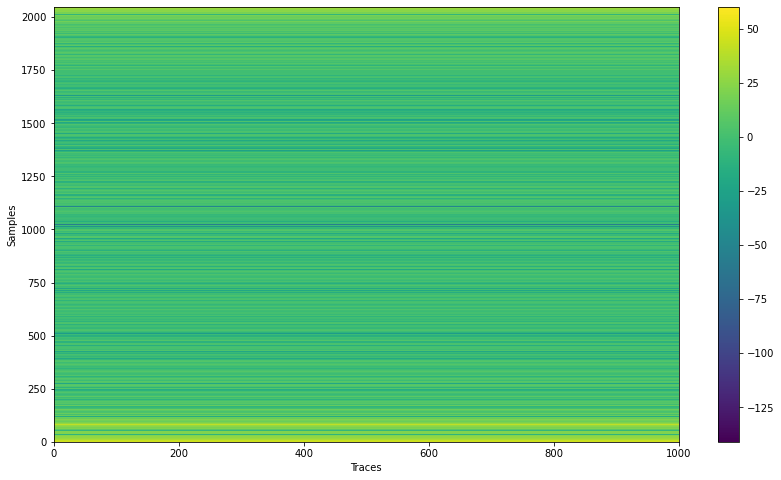

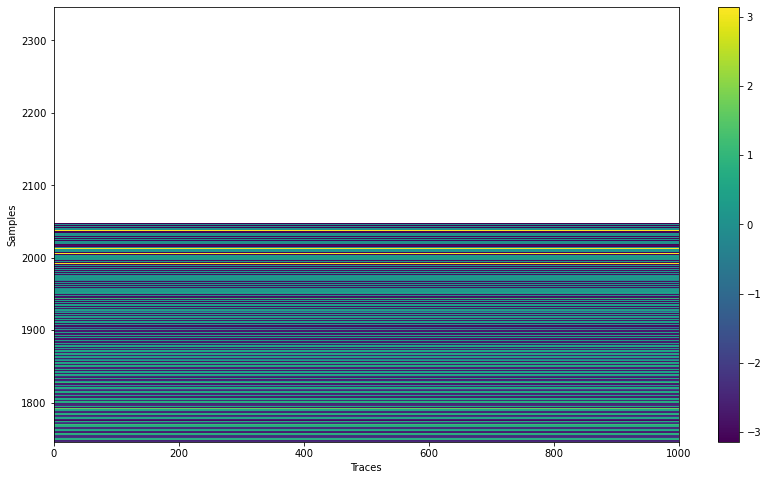

In [12]:
# do pulse compression using fft method -- with extra zero padding
# TODO: CURRENTLY NOT DOING ANYTHING TO REMOVE NON-VALID SAMPLES
nfft = 2048 # number of samples in fft

data_tx_fft = np.fft.fft(ref_chirp, nfft)
data_tx_fft = np.tile(data_tx_fft, (data_rx_stacked.shape[1], 1)).transpose()
print(data_tx_fft.shape)

data_rx_fft = np.fft.fft(data_rx_stacked, n=nfft, axis=0)

pc_fft = data_rx_fft * np.conjugate(data_tx_fft)
pc_zp = np.fft.ifft(pc_fft, axis=0)
#pc = np.fft.ifftshift(pc_zp)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_zp))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)

# fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
# im = ax.pcolormesh(20*np.log10(np.abs((pc))))
# ax.set_xlabel('Traces')
# ax.set_ylabel('Samples')
# ax.set_ylim((2046-300, 2046+300))
# fig.colorbar(im, ax=ax)

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(np.angle((pc_zp)))
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
ax.set_ylim((2046-300, 2046+300))
fig.colorbar(im, ax=ax)

In [ ]:
# extract phase of the pulse compressed peak
# surface_idx_min, surface_idx_max = 750, 756
# bed_idx_min, bed_idx_max = 827, 833
surface_idx = 2051
bed_idx = 2128

print(pc.shape)
surface_phase = np.angle(pc[surface_idx,:])
bed_phase = np.angle(pc[bed_idx,:])

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(surface_phase, label='Surface')
ax.plot(bed_phase, label='Bed')
ax.set_xlabel('Traces')
ax.set_ylabel('Phase (rad)')
ax.legend()

In [ ]:
surface_snr = estimate_snr(pc, 2051, 1000)
bed_snr = estimate_snr(pc, 2128, 1000)

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(10*np.log10(surface_snr), label='Surface')
ax.plot(10*np.log10(bed_snr), label='Bed')
ax.set_xlabel('Trace')
ax.set_ylabel('SNR (dB)')
ax.legend()

### Do processing via correlation

(501, 1000)
(1500, 1000)
(1000,)


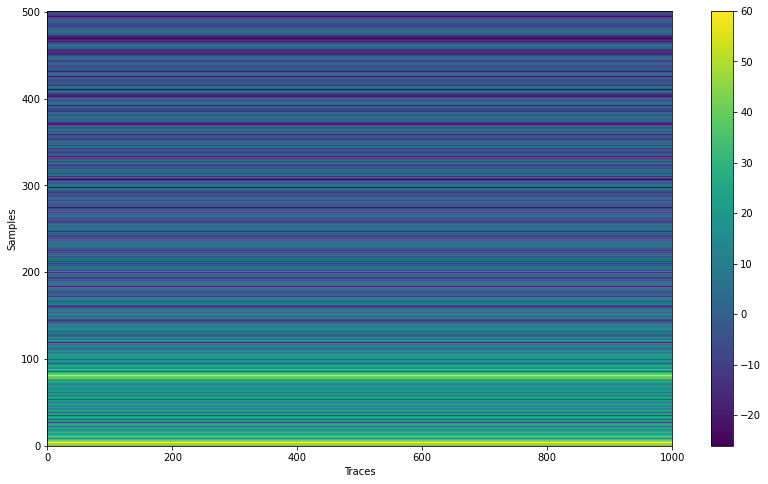

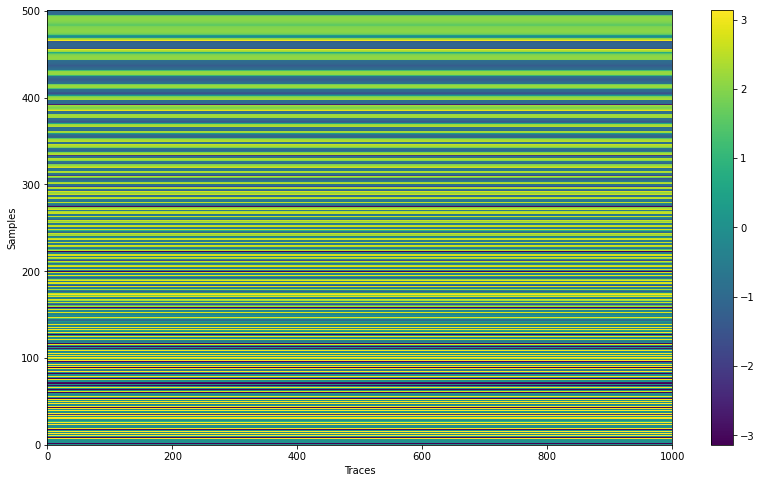

In [13]:
# Thomas' correlation code (performed for each slow time trace): 
#xcorr_results[:, res_idx] = sp.correlate(stacked, corr_sig, mode='valid', method='auto') / np.sum(np.abs(corr_sig)**2)
pc_corr = np.zeros((num_rx_samples - len(ref_chirp) + 1, data_rx_stacked.shape[1]), dtype=np.complex64)

for tr in range(0, data_rx_stacked.shape[1]):
    pc_corr[:,tr] = sp.correlate(data_rx_stacked[:,tr], ref_chirp, mode='valid', method='auto')
    
fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_corr))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)

print(pc_corr.shape)
print(data_rx_stacked.shape)
print(ref_chirp.shape)


fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(np.angle((pc_corr)))
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
#ax.set_ylim((2046-300, 2046+300))
fig.colorbar(im, ax=ax)

In [ ]:
# extract phase of the pulse compressed peak
# surface_idx_min, surface_idx_max = 750, 756
# bed_idx_min, bed_idx_max = 827, 833
surface_idx = 3
bed_idx = 80

print(pc.shape)
surface_phase = np.angle(pc_corr[surface_idx,:])
bed_phase = np.angle(pc_corr[bed_idx,:])

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(surface_phase, label='Surface')
ax.plot(bed_phase, label='Bed')
ax.set_xlabel('Traces')
ax.set_ylabel('Phase (rad)')
ax.legend()

In [ ]:
surface_snr = estimate_snr(pc_corr, 3, 1000)
bed_snr = estimate_snr(pc_corr, 80, 1000)

fig, ax = plt.subplots(1,1, figsize=(6,4), facecolor='white')
ax.plot(10*np.log10(surface_snr), label='Surface')
ax.plot(10*np.log10(bed_snr), label='Bed')
ax.set_xlabel('Trace')
ax.set_ylabel('SNR (dB)')
ax.legend()

### Compare results of FFT-based and correlation-based implementations

Text(0.5, 1.0, 'Direct Implementation Num RX Samps - Direct Implementation Num RX Samps')

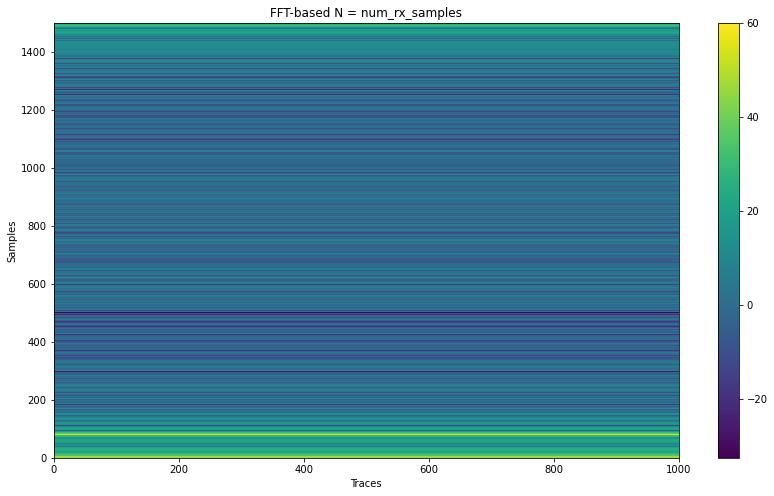

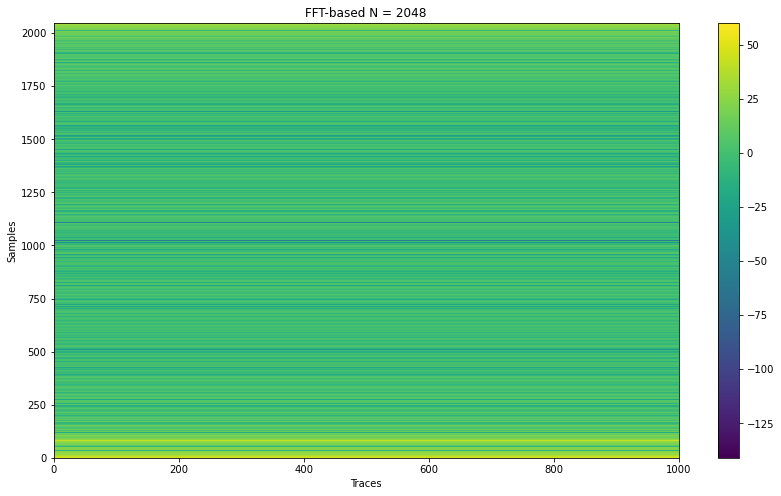

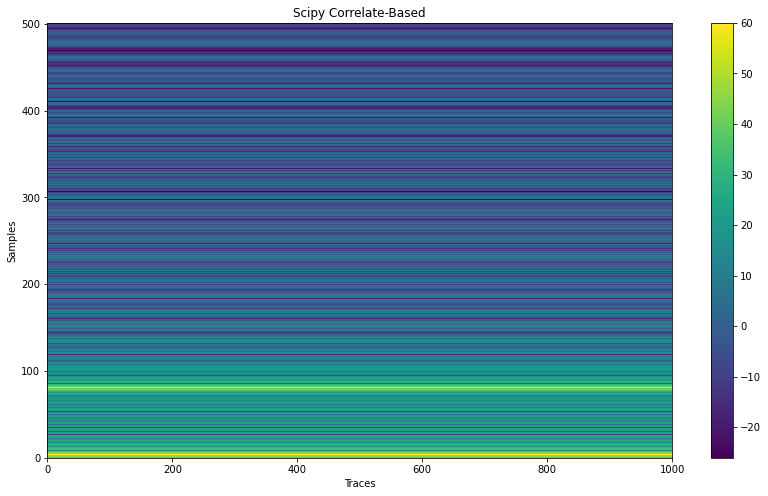

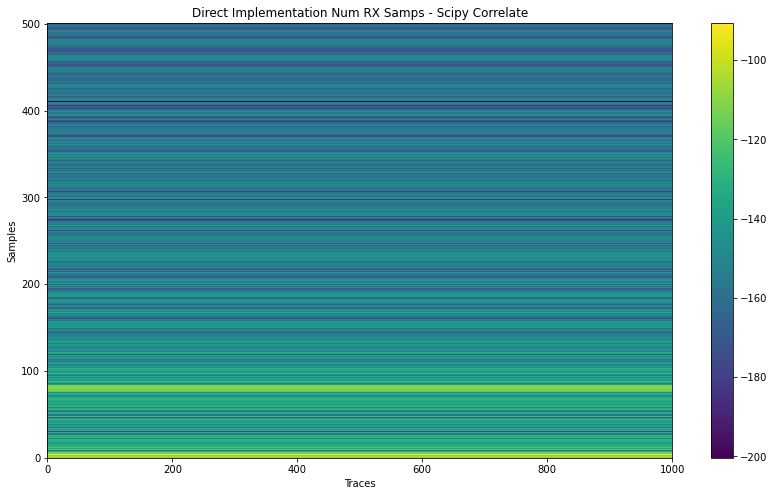

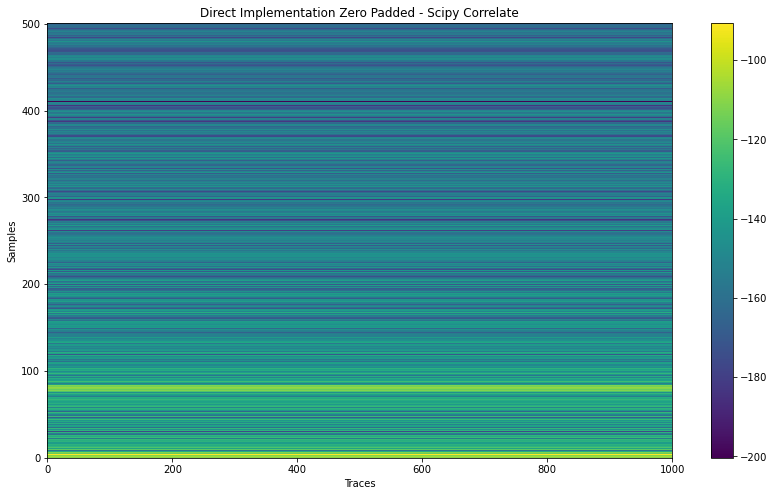

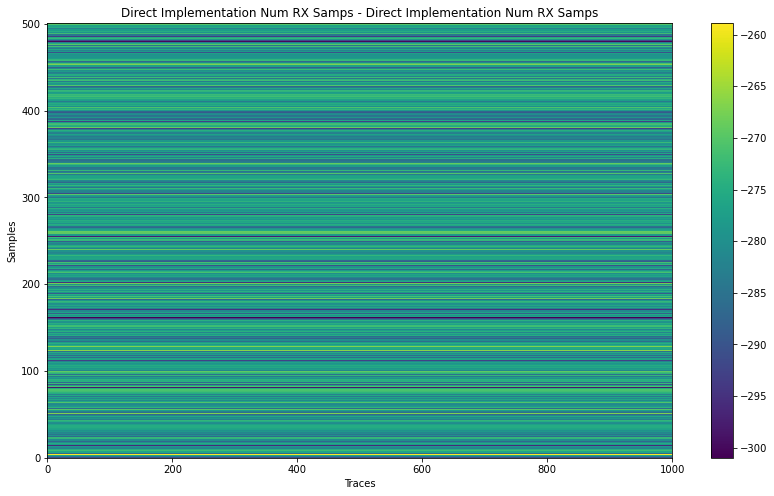

In [15]:
#pc_nrxsamps = np.fft.fftshift(pc_nrxsamps)
#pc_zp = np.fft.fftshift(pc_zp)
pc_nrxsamps_corr = pc_nrxsamps[:num_rx_samples - len(ref_chirp) + 1,:] - pc_corr
pc_zp_corr = pc_zp[:num_rx_samples - len(ref_chirp) + 1,:] - pc_corr
pc_nrxsamps_zp = pc_nrxsamps[:num_rx_samples - len(ref_chirp) + 1,:] - pc_zp[:num_rx_samples - len(ref_chirp) + 1,:] 

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_nrxsamps))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)
ax.set_title('FFT-based N = num_rx_samples')

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_zp))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)
ax.set_title('FFT-based N = 2048')

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_corr))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)
ax.set_title('Scipy Correlate-Based')

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_nrxsamps_corr))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)
ax.set_title('Direct Implementation Num RX Samps - Scipy Correlate')

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_zp_corr))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)
ax.set_title('Direct Implementation Zero Padded - Scipy Correlate')

fig, ax = plt.subplots(1,1, figsize=(14, 8), facecolor='white')
im = ax.pcolormesh(20*np.log10(np.abs(pc_nrxsamps_zp))) # should be ifftshift here
ax.set_xlabel('Traces')
ax.set_ylabel('Samples')
fig.colorbar(im, ax=ax)
ax.set_title('Direct Implementation Num RX Samps - Direct Implementation Num RX Samps')

# print(np.max(pc_comparison))
# print(np.max(np.abs(pc_comparison)))
# print(np.max(np.abs(pc_comparison[80,:])))

### Understand Spectrums with a Simple Example

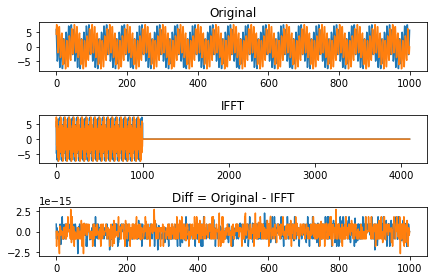

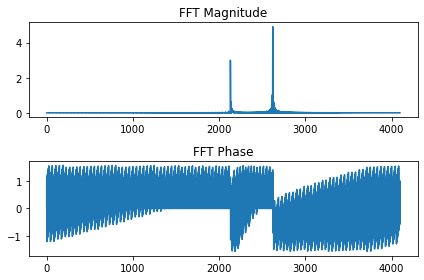

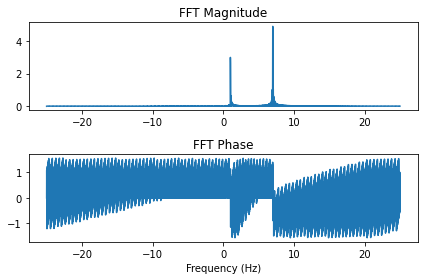

In [29]:
#test_signal =  ref_chirp 
test_signal = 3 * (np.cos(2 * np.pi * 1e6 * ts + 1.2) + 1j * np.sin(2 * np.pi * 1e6 * ts + 1.2))
test_signal += 5 * (np.cos(2 * np.pi * 7e6 * ts + 0.3) + 1j * np.sin(2 * np.pi * 7e6 * ts + 0.3))
nfft = 4096 #test_signal.size
test_signal_fft = np.fft.fft(test_signal, nfft) / test_signal.size
test_signal_ifft = np.fft.ifft(test_signal_fft * test_signal.size, nfft)

diff = test_signal - test_signal_ifft[0:test_signal.size]

fig, axs = plt.subplots(3,1)
axs[0].plot(np.real(test_signal))
axs[0].plot(np.imag(test_signal))
axs[0].set_title('Original')
axs[1].plot(np.real(test_signal_ifft))
axs[1].plot(np.imag(test_signal_ifft))
axs[1].set_title('IFFT')
axs[2].plot(np.real(diff))
axs[2].plot(np.imag(diff))
axs[2].set_title('Diff = Original - IFFT')
fig.tight_layout()

# remove divide by almost zero errors to improve phase estimation
# e.g. https://www.gaussianwaves.com/2015/11/interpreting-fft-results-obtaining-magnitude-and-phase-information/
test_signal_fft[test_signal_fft < np.max(test_signal_fft)/(1e10)] = 0

fig, axs = plt.subplots(2,1)
axs[0].plot(np.fft.fftshift(np.abs(test_signal_fft)))
axs[0].set_title('FFT Magnitude')
axs[1].plot(np.fft.fftshift(np.angle(test_signal_fft)))
axs[1].set_title('FFT Phase')
fig.tight_layout()

freqs = np.fft.fftshift(np.fft.fftfreq(nfft, d=1/fs))

fig, axs = plt.subplots(2,1)
axs[0].plot(freqs/(1e6), np.fft.fftshift(np.abs(test_signal_fft)))
axs[0].set_title('FFT Magnitude')
axs[1].plot(freqs/(1e6), np.fft.fftshift(np.angle(test_signal_fft)))
axs[1].set_title('FFT Phase')
axs[1].set_xlabel('Frequency (Hz)')
fig.tight_layout()

# freqs = np.fft.fftshift(np.fft.fftfreq(chirp.size, d=1/fs))
# chirp_fft = np.fft.fftshift(20*np.log10(np.abs(np.fft.fft(chirp))))
# axs[1].plot(freqs/1e6, chirp_fft)
# axs[1].set_xlabel('Frequency [MHz]')
# axs[1].set_ylabel('Power [dB]')
# axs[1].set_title('Chirp -- Frequency Domain')
# axs[1].grid()
# fig.tight_layout()